# Implementing an individual-based model (IBM) of mussel aggregation

In the prior sections, you have studied how localized interactions can affect the spatial structure of a population or ecosystem. But what if we want to model, for instance, the movement of fish in a school, or the movement of a limited number of predators in a landscape (think of a small number of puma in an American park). For that, we can’t use a model that puts the individuals on a lattice of equal-sized cells, but we should explicitly model the location of the animals in a two-dimensional or three-dimensional space. 

In this chapter, we will implement a model from the general class of *agent-based models*. The term agent is used throughout science to indicate an autonomous unit that can make decisions to achieving a particular goal, and that adapts these decisions to changes in the environment or situation that it experiences. In ecology, an agent is often an individual organism. Each individual organism is described by a set of characteristics, for instance it’s coordinates in space, it’s size, or whether it is hungry or not (e.g., a state). 

A cellular automaton can be used to model sessile individuals such as plants on a square lattice. Cellular automata are very simple to model, but have the disadvantage that the organisms cannot simply move around, and can only be described by a limited number of states. When modeling a school of fish, a cellular automaton is obviously too limited. We need to develop a program in which for instance the changes in the organism’s physical location, its’ growth and its decisions are explicitly modeled. Below, we will develop a simple individual-based model in Python, using self-organized patch formation of mussels as an example.

![Mussel aggregation patterns](https://johanvandekoppel.files.wordpress.com/2013/07/cropped-20130703-112450.jpg)

### Self-organized mussel patterns

In intertidal environments, many organisms attach strongly to a surface, for instance a rock, to avoid being dislodged by waves and water flow. Mussels in the rocky intertidal, for instance, attach to the rock surface with byssus threads. On sandy sediment, no firm substrate is available, so mussels attach to each other, forming clumps and strings of mussels (see figure 1). These strings and clumps can form self-organized patterns that look very similar to the patterns formed in arid ecosystems (e.g, leopard bush). 

A laboratory study on mussel aggregation dynamics revealed that mussels can aggregated to produce these spatial patterns on very short timescales, e.g., within a day.

The citation is:  
*Van de Koppel, J., Gascoigne, J.C., Theraulaz, G., Rietkerk, M., Mooij W.M., & Herman, P.M.J. 2008 Experimental evidence for spatial self-organization and its emergent effects in mussel beds. Science 322:739-742.*

When the relation between the movement speed and the number of neighbors was investigated, a complex behavior was observed. The behavior can be summarized as follows:  
•	Mussels move with high speed when they are alone.  
•	When the number of mussels in the direct neighborhoods increases, mussel movement speed decreases.  
•	When the number of mussels in the total aggregate, at a scale of +- 10 cm, increases too much, mussels again start to move faster, moving out of clusters that are too large.  

In this section, we will model the movement of mussels to test whether the above description of individual movement is sufficient to recreate the patterns that are described in the paper. For this, we will describe mussel movement, in terms of its step size and direction per time unit, as a stochastic process, e.g., a random walk. The step size is not entirely random, of course, but is a function of the local density of mussels. Inspection of the data revealed that the mussels do random walk that is best described by an exponential distribution of step sizes:  
$$
\begin{aligned}
F(x)= \frac{1}{β} exp \big(\frac{-x}{β}\big), 
\end{aligned}
$$

Here, x is the step size and β a scaling parameter).

Below, we implement this model in Python

### Loading required modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time, os
%matplotlib inline

### Parameter definition 

In [3]:
N            =  2000;    # Total number of mussels
Length       =  50.0;    # Length of the arena 
EndTime      =   300;    # 300 - Number of timesteps in minutes

# Parameters of the function relating density to movement speed
P1           = 100.0;    # 100
P2           = -80.0;    # -80
P3           =   3.0;    # 3

D1           =   2.0;    # 2 - Size of the direct neighborhood
D2           =   6.0;    # 6 - Size of the cluster neighborhood

### Graphical parameters

In [4]:
WinWidth     =   960;    #   - Width of the simulation window 
WinHeight    =   720;    #   - Height of the simulation window

MusselSize   = (1500.0/Length)  # Size of the marker

### Array declarations

In [5]:
Stepsize  = np.zeros(N)
Angle     = np.zeros(N)
Distance  = np.zeros((N,N))
Diagonal  = np.zeros((N,N))
np.fill_diagonal(Diagonal, 1)

## Randomly distributing the data across the domain
X=np.random.rand(N)*Length
Y=np.random.rand(N)*Length

### Function computing the distance matrix

In [6]:
def dist(x,y):
    dx = x[..., np.newaxis] - x[np.newaxis, ...]
    dy = y[..., np.newaxis] - y[np.newaxis, ...]
    d = np.array([dx,dy])
    return (d**2).sum(axis=0)**0.5

In [7]:
from numba import njit,prange

@njit(parallel=True)
def distp(x,y):
    d = np.zeros((x.shape[0],y.shape[0]))
    for j in prange(y.shape[0]):
        for i in prange(x.shape[0]): 
            d[i,j]=np.sqrt( (x[j]-x[i])**2 + (y[j]-y[i])**2)
    return d

### Main simulation loop

In [8]:
# Storage variables
Xs=np.zeros((N,EndTime))
Ys=np.zeros((N,EndTime))

# Setting up time profiling
start_time = time.time()

for Time in range(EndTime):
    
    # Calculating distances between all individual mussels
    Distance=dist(X,Y);
  
    # Checking which mussels are within ranges D1 and D2
    Nr_In_Dist1 = (Distance<D1)*1.0-Diagonal;
    Nr_In_Dist2 = (Distance<D2)*1.0-Diagonal; 
  
    # Calculating, for each mussel, the density of the local neighborhood
    Density_In_Dist1 = Nr_In_Dist1.sum(axis=0)/(D1**2*np.pi); # sum/surface
    Density_In_Dist2 = Nr_In_Dist2.sum(axis=0)/(D2**2*np.pi); # sum/surface
  
    # Determining StepSize and Angle from the Densities
    Beta = 1/(np.maximum(0.001,P1*Density_In_Dist1+P2*Density_In_Dist2)+P3);
    Stepsize = - Beta * np.log(np.random.rand(N));
    Angle = np.random.rand(N)*360.0;
  
    # Converting Speed S en Angle A to new X and Y coordinates
    X = X + np.sin(Angle/180.0*np.pi)*Stepsize;
    Y = Y + np.cos(Angle/180.0*np.pi)*Stepsize;
  
    #Boundary Conditions, mussels are moved back to the domain if out
    X = X + Length*(X<0) - Length*(X>Length)
    Y = Y + Length*(Y<0) - Length*(Y>Length)    

    Xs[:,Time]=X
    Ys[:,Time]=Y

elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 31.6 (s)


### Plotting the results

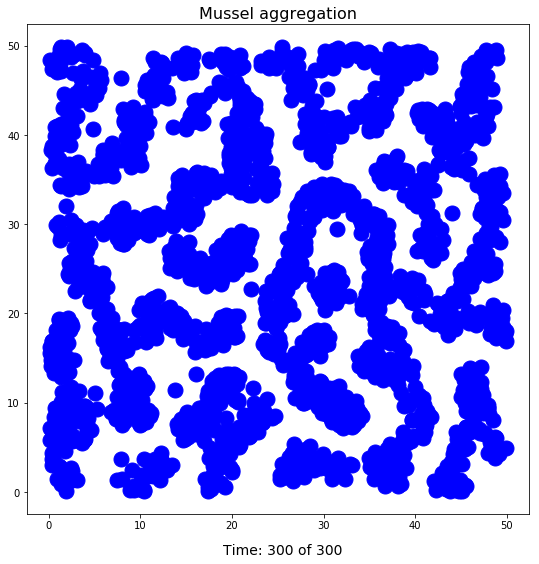

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
P, = ax.plot(X,Y, 'b.', markersize=MusselSize);
ax.set_title("Mussel aggregation", fontsize=16)
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime, EndTime)), x=0.52, y=0.08, fontsize=14);

### Making an animation

In [10]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    P.set_xdata(Xs[:,i])
    P.set_ydata(Ys[:,i])
    text.set_text("Time: %01.0f of %1.0f" % (i+1, EndTime));
    return P,

ani = animation.FuncAnimation(fig, updatefig, 
                              interval=100, frames = EndTime, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

© Johan van de Koppel, NIOZ-Yerseke 2018